In [2]:
import sys, os

MARIPOSA_PATH = "/home/yizhou7/mariposa/"

sys.path.append(MARIPOSA_PATH + "src")
os.chdir(MARIPOSA_PATH)

from debugger.options import DbgMode
from debugger.strainer import DebugStatus
from bench.consts import *
from base.factory import FACT

import random
import numpy as np

In [ ]:
mp = FACT.get_project_by_path("data/projs/bench_unstable/base.z3")

exp = FACT.load_analysis(
        mp,
        cfg=FACT.get_config("default"),
        solver=FACT.get_solver("z3_4_12_5"),
        ana=FACT.get_analyzer("60sec"),
        allow_missing_exper=False,
    )

random.seed(9321743958)

mariposa_ets = []

for qid in exp.qids:
    qr = exp[qid]
    passed, failed = exp.get_mutant_details(qr)
    adjusted = dict()

    for k, woot in passed.items():
        if woot[3] >= 60:
            failed[k] = woot
        else:
            adjusted[k] = woot   
    passed = adjusted    

    fmut = random.choice(list(failed.keys()))
    _, _, _, fet = failed[fmut]
    pmut = random.choice(list(passed.keys()))
    _, _, _, pet = passed[pmut]
    mariposa_ets += [(fet, pet)]

# fstar_queries = np.array(fstar_queries)
# dafny_queries = np.array(dafny_queries)
mariposa_ets = np.array(mariposa_ets)


In [4]:
verus_ets = []
for p in VERUS_PROJS:
    proj = FACT.get_project_by_path("data/projs/" + p + "/base.z3")
    exp = FACT.load_analysis(
        proj,
        cfg=FACT.get_config("default"),
        solver=FACT.get_solver("z3_4_13_0"),
        ana=FACT.get_analyzer("10sec"),
        allow_missing_exper=False,
    )
    for qid in exp.qids:
        qer = exp[qid]
        if qer.query_path not in UNSTABLE_VERUS:
            continue
        passed, failed = exp.get_mutant_details(qer)
        adjusted = dict()
        for k, woot in passed.items():
            if woot[3] >= 10:
                failed[k] = woot
            else:
                adjusted[k] = woot   
        passed = adjusted
        fmut = random.choice(list(failed.keys()))
        _, _, _, fet = failed[fmut]
        pmut = random.choice(list(passed.keys()))
        _, _, _, pet = passed[pmut]
        verus_ets += [(fet, pet)]
    
verus_ets = np.array(verus_ets)

In [5]:
from utils.analysis_utils import *
from utils.plot_utils import *

mariposa_ets = mariposa_ets.clip(0, 60)
assert mariposa_ets.shape[0] == len(UNSTABLE_MARIPOSA)

verus_ets = verus_ets.clip(0, 10)
assert verus_ets.shape[0] == len(UNSTABLE_VERUS)

In [6]:
mariposa_fail_cdf = PartialCDF(mariposa_ets[:,0])
# mariposa_pass_cdf = PartialCDF(mariposa_ets[:,1])
verus_fail_cdf = PartialCDF(verus_ets[:,0])
# verus_pass_cdf = PartialCDF(verus_ets[:,1])

In [7]:
# plt.scatter(verus_ets[:,0], verus_ets[:,1], c="orange")
# plt.scatter(mariposa_ets[:,0], mariposa_ets[:,1], c="blue")

# # Adding labels and title to the scatter plot
# plt.xlabel("Mutant Failure Time Log Scale (s)")
# plt.ylabel("Mutant Success Time Log Scale (s)")
# # plt.title("Scatter Plot of Execution Times")
# plt.xlim(0.02, 60.2)
# plt.xticks([0.02, 0.1, 1, 10, 60], ["", "0.1", "1.0", "10.0", "60.0"])

# plt.ylim(0.02, 60.2)
# plt.yticks([0.02, 0.1, 1, 10, 60], ["", "0.1", "1.0", "10.0", "60.0"])

# plt.gca().set_aspect('equal', adjustable='box')
# plt.tight_layout()
# plt.legend(["Mariposa-bench", "Verus-bench"], loc="upper left")
# plt.grid()
# plt.xscale("log")
# plt.yscale("log")
# plt.savefig("fig/debugger/pass_fail.pdf", dpi=300)
# plt.close()

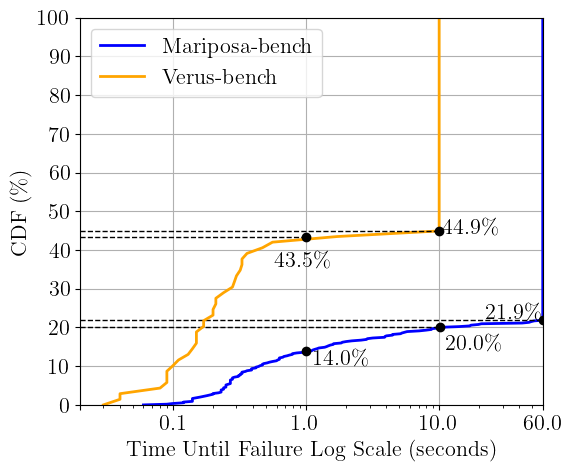

In [8]:
fig, ax = plt.subplots(figsize=(6, 5))  # Figure size (width, height)

ax.plot(
    mariposa_fail_cdf.xs,
    mariposa_fail_cdf.ys,
    label="Mariposa-bench",
    color="blue",
    linewidth=2,
)

x, y = mariposa_fail_cdf.get_point_by_value(10, True)
ax.plot(x, y, c="black", marker="o")
ax.text(x * 1.1, y -2, f"{round(y, 1)}\%",  va="top", ha="left")
ax.hlines(y, 0, x, color="black", linestyle="--", linewidth=1)

x, y = mariposa_fail_cdf.get_point_by_value(1, True)
ax.plot(1, y, c="black", marker="o")
ax.text(x * 1.05, y, f"{round(y, 1)}\%",  va="top")

x, y = mariposa_fail_cdf.get_point_by_value(59.1, True)
ax.plot(x, y, c="black", marker="o")
ax.text(x * 1, y + 4, f"{round(y, 1)}\%", va="top", ha="right")
ax.hlines(y, 0, x, color="black", linestyle="--", linewidth=1)

ax.plot(
    verus_fail_cdf.xs,
    verus_fail_cdf.ys,
    label="Verus-bench",
    color="orange",
    linewidth=2,
)

x, y = verus_fail_cdf.get_point_by_value(0.8, False)
ax.plot(1, y, c="black", marker="o")
ax.text(x/3, y-4, f"{round(y, 1)}\%", va="top", ha="left")
ax.hlines(y, 0, 1, color="black", linestyle="--", linewidth=1)

x, y = verus_fail_cdf.get_point_by_value(9.9, True)
ax.plot(x, y, c="black", marker="o")
ax.text(x * 1.05, y + 3, f"{round(y, 1)}\%", va="top", ha="left")
ax.hlines(y, 0, x, color="black", linestyle="--", linewidth=1)

# plt.axvline(x=1, ymin=0, ymax=0.42,color='gray', linestyle='--')
# plt.axhline(y=42, xmin=0, xmax=0.5, color='gray', linestyle='--')

ax.set_xscale("log")
ax.grid()

ax.set_yticks(np.arange(0, 101, 10))
ax.set_xlim(0.02, 60.2)
ax.set_xticks([0.02, 0.1, 1, 10, 60], ["", "0.1", "1.0", "10.0", "60.0"])
ax.set_ylim(0, 100)

plt.legend()
# plt.title("Distinct Instability Failure Modes")
plt.xlabel("Time Until Failure Log Scale (seconds)")
plt.ylabel("CDF (\%)")

plt.tight_layout()
plt.savefig("fig/debugger/failure_modes.pdf", dpi=300, bbox_inches="tight", pad_inches=0.1)